## Imports


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from constants import GROUP_TO_ANALYZE, DATES

По времени загрузки ответа, можно анализировать:

1. кто из студентов выбивается из общей картины по времени загрузки ответа в зависимости от типа задания
2. кто из студентов выбивается из общей картины по количеству попыток в зависимости от типа задания


Графики, которые можно сделать:

1. swarmplot по времени загрузки ответа в зависимости от группы, чтобы найти тенденции преуспевающих групп
2. heatmap по студентам, задачам и количеству неудачных попыток в группе, чтобы явно посмотреть на отстающие темы у студентов


## Data preparation


In [2]:
# import data with pandas
df = pd.read_csv(
    "data/output.csv",
    names=["group", "task", "variant", "time", "status", "student", "achievement"],
)
df.head()

group  task  variant                        time  status  student  \
0      1     0       39  2023-02-08 22:09:13.821983       3        1   
1      1     0       38  2023-02-08 22:10:44.827760       2        1   
2     14     0        5  2023-02-09 10:06:55.747618       3       19   
3     14     0       26  2023-02-09 10:07:02.387588       3        3   
4     14     0        5  2023-02-09 10:08:43.042587       3       19   

   achievement  
0          NaN  
1          0.0  
2          NaN  
3          NaN  
4          NaN

In [3]:
df_dates = pd.DataFrame(
    DATES.items(),
    columns=["task", "task_release_date"],
)
df_dates

task task_release_date
0      0        2023-02-08
1      1        2023-02-15
2      2        2023-02-15
3      3        2023-02-15
4      4        2023-02-15
5      5        2023-02-26
6      6        2023-02-26
7      7        2023-03-04
8      8        2023-03-12
9      9        2023-03-18
10    10        2023-04-01

### Functions


In [4]:
def box_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    mask = (series < Q1 - 1.5 * IQR) | (series > Q3 + 1.5 * IQR)
    series = series[mask]
    return series

In [5]:
def box_borders(series):
    mean = series.median()
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    mask = (series >= Q1 - 1.5 * IQR) & (series <= Q3 + 1.5 * IQR)
    series_no_outliers = series[mask]
    l_whisker = series_no_outliers.min()
    h_whisker = series_no_outliers.max()
    l_outliers = series.min()
    h_outliers = series.max()
    # print(mean, Q1, Q3, l_whisker, h_whisker, l_outliers, h_outliers)
    return [mean, Q1, Q3, l_whisker, h_whisker, l_outliers, h_outliers]

### Main DataFrame with timeseries data


In [6]:
online_df = pd.DataFrame()
outliers_by_number_of_tries_df = pd.DataFrame()
outliers_by_date_df = pd.DataFrame()
successes_df = pd.DataFrame(
    columns=["group", "task", "variant", "time", "status", "student", "achievement"]
)
sorted_by_date_df = df.copy().sort_values(["time"])
history_borders_number_of_tries = dict()
history_borders_date = dict()

In [7]:
# sorted_by_date_df = sorted_by_date_df[sorted_by_date_df["task"] == 0]
# last_date = sorted_by_date_df.groupby(["student"], as_index=False).agg(
#     last_date=("time", "max")
# )
# last_date["period"] = (
#     pd.to_datetime(last_date["last_date"]) - DATES[0]
# ) / pd.Timedelta(hours=1)
# last_date
# box_borders(last_date["period"])

In [8]:
for index, row in sorted_by_date_df.copy().iterrows():
    if row["status"] == 2:
        successes_df = pd.concat([successes_df, pd.DataFrame([row])])
        # online_df = online_df[
        #     ~(
        #         (online_df["student"] == row["student"])
        #         & (online_df["task"] == row["task"])
        #     )
        # ]
        continue
    if successes_df[
        (successes_df["student"] == row["student"])
        & (successes_df["task"] == row["task"])
    ].empty:
        online_df = pd.concat([online_df, pd.DataFrame([row])])
        current_task_df = online_df[online_df["task"] == row["task"]]
        num_attempts_by_student_df = current_task_df.groupby(
            ["student"], as_index=False
        ).agg(num_attempts=("time", "size"))
        num_attempts_by_student_df = num_attempts_by_student_df[
            ["student", "num_attempts"]
        ]
        time_period_df = current_task_df.groupby(["student"], as_index=False).agg(
            last_date=("time", "max")
        )
        time_period_df["period"] = (
            pd.to_datetime(time_period_df["last_date"]) - DATES[row["task"]]
        ) / pd.Timedelta(hours=1)
        time_period_df = time_period_df[["student", "period"]]
        history_borders_number_of_tries.setdefault(row["task"], [])
        history_borders_number_of_tries[row["task"]].append(
            box_borders(num_attempts_by_student_df["num_attempts"])
        )
        history_borders_number_of_tries[row["task"]][-1].append(row["time"])
        history_borders_date.setdefault(row["task"], [])
        history_borders_date[row["task"]].append(box_borders(time_period_df["period"]))
        history_borders_date[row["task"]][-1].append(row["time"])
        df_outlier_attempts = (
            num_attempts_by_student_df.set_index("student")
            .apply(box_outliers)
            .reset_index()
        )
        df_outlier_attempts["time"] = row["time"]
        df_outlier_attempts["task"] = row["task"]
        if outliers_by_number_of_tries_df.empty:
            outliers_by_number_of_tries_df = df_outlier_attempts
        else:
            outliers_by_number_of_tries_df = pd.concat(
                [
                    outliers_by_number_of_tries_df[
                        outliers_by_number_of_tries_df["task"] != row["task"]
                    ],
                    df_outlier_attempts,
                ]
            )
        df_outlier_period = (
            time_period_df.set_index("student").apply(box_outliers).reset_index()
        )
        df_outlier_period["time"] = row["time"]
        df_outlier_period["task"] = row["task"]
        if outliers_by_date_df.empty:
            outliers_by_date_df = df_outlier_period
        else:
            outliers_by_date_df = pd.concat(
                [
                    outliers_by_date_df[outliers_by_date_df["task"] != row["task"]],
                    df_outlier_period,
                ]
            )
    # if index == 10:
    #     break

In [ ]:
def get_stat_data(df, number_of_rows=None):
    online_df = pd.DataFrame()
    outliers_by_number_of_tries_df = pd.DataFrame()
    successes_df = pd.DataFrame(columns=df.columns)
    sorted_by_date_df = df.copy().sort_values(["time"])
    history_borders_number_of_tries = dict()

    for index, row in sorted_by_date_df.copy().iterrows():
        if row["status"] == 2:
            successes_df = pd.concat([successes_df, pd.DataFrame([row])])
            continue
        if successes_df[
            (successes_df["student"] == row["student"])
            & (successes_df["task"] == row["task"])
        ].empty:
            online_df = pd.concat([online_df, pd.DataFrame([row])])
            current_task_df = online_df[online_df["task"] == row["task"]]
            num_attempts_by_student_df = current_task_df.groupby(
                ["student"], as_index=False
            ).agg(num_attempts=("time", "size"))
            num_attempts_by_student_df = num_attempts_by_student_df[
                ["student", "num_attempts"]
            ]
            history_borders_number_of_tries.setdefault(row["task"], [])
            history_borders_number_of_tries[row["task"]].append(
                box_borders(num_attempts_by_student_df["num_attempts"])
            )
            history_borders_number_of_tries[row["task"]][-1].append(row["time"])
            df_outlier_attempts = (
                num_attempts_by_student_df.set_index("student")
                .apply(box_outliers)
                .reset_index()
            )
            df_outlier_attempts["time"] = row["time"]
            df_outlier_attempts["task"] = row["task"]
            if outliers_by_number_of_tries_df.empty:
                outliers_by_number_of_tries_df = df_outlier_attempts
            else:
                outliers_by_number_of_tries_df = pd.concat(
                    [
                        outliers_by_number_of_tries_df[
                            outliers_by_number_of_tries_df["task"] != row["task"]
                        ],
                        df_outlier_attempts,
                    ]
                )
        if number_of_rows is not None and index == number_of_rows:
            break

In [10]:
# for index, row in sorted_by_date_df.copy().iterrows():
#     if row["status"] == 2:
#         successes_df = pd.concat([successes_df, pd.DataFrame([row])])
#         # online_df = online_df[
#         #     ~(
#         #         (online_df["student"] == row["student"])
#         #         & (online_df["task"] == row["task"])
#         #     )
#         # ]
#         continue
#     if successes_df[
#         (successes_df["student"] == row["student"])
#         & (successes_df["task"] == row["task"])
#     ].empty:
#         online_df = pd.concat([online_df, pd.DataFrame([row])])
#         current_task_df = online_df[online_df["task"] == row["task"]]
#         num_attempts_by_student_df = current_task_df.groupby(
#             ["student"], as_index=False
#         ).agg(num_attempts=("time", "size"))
#         num_attempts_by_student_df = num_attempts_by_student_df[
#             ["student", "num_attempts"]
#         ]
#         time_period_df = current_task_df.groupby(["student"], as_index=False).agg(
#             last_date=("time", "max")
#         )
#         time_period_df["period"] = (
#             pd.to_datetime(time_period_df["last_date"]) - DATES[row["task"]]
#         ) / pd.Timedelta(hours=1)
#         time_period_df = time_period_df[["student", "period"]]
#         history_borders_number_of_tries.setdefault(row["task"], [])
#         history_borders_number_of_tries[row["task"]].append(
#             box_borders(num_attempts_by_student_df["num_attempts"])
#         )
#         history_borders_number_of_tries[row["task"]][-1].append(row["time"])
#         history_borders_date.setdefault(row["task"], [])
#         history_borders_date[row["task"]].append(box_borders(time_period_df["period"]))
#         history_borders_date[row["task"]][-1].append(row["time"])
#         df_outlier_attempts = (
#             num_attempts_by_student_df.set_index("student")
#             .apply(box_outliers)
#             .reset_index()
#         )
#         df_outlier_attempts["time"] = row["time"]
#         df_outlier_attempts["task"] = row["task"]
#         if outliers_by_number_of_tries_df.empty:
#             outliers_by_number_of_tries_df = df_outlier_attempts
#         else:
#             outliers_by_number_of_tries_df = pd.concat(
#                 [
#                     outliers_by_number_of_tries_df[
#                         outliers_by_number_of_tries_df["task"] != row["task"]
#                     ],
#                     df_outlier_attempts,
#                 ]
#             )
#         df_outlier_period = (
#             time_period_df.set_index("student").apply(box_outliers).reset_index()
#         )
#         df_outlier_period["time"] = row["time"]
#         df_outlier_period["task"] = row["task"]
#         if outliers_by_date_df.empty:
#             outliers_by_date_df = df_outlier_period
#         else:
#             outliers_by_date_df = pd.concat(
#                 [
#                     outliers_by_date_df[outliers_by_date_df["task"] != row["task"]],
#                     df_outlier_period,
#                 ]
#             )
#     # if index == 10:
#     #     break

In [11]:
stat_data_num = [list(zip(*task)) for task in history_borders_number_of_tries.values()]
stat_data_date = [list(zip(*task)) for task in history_borders_date.values()]
stat_data_date

[[(22.153839439722223,
   28.134662444583334,
   34.11548544944444,
   34.117329885555556,
   34.1452896075,
   34.1452896075,
   34.173211655277775,
   34.17695969458333,
   34.17695969458333,
   34.17695969458333,
   34.18070773388889,
   34.365475098888886,
   34.365475098888886,
   34.365475098888886,
   34.365475098888886,
   34.400251268055555,
   34.400251268055555,
   34.435027437222224,
   34.435027437222224,
   34.435027437222224,
   34.55435524986111,
   34.6736830625,
   34.6736830625,
   34.6736830625,
   34.71633777472222,
   34.71633777472222,
   34.71633777472222,
   34.71633777472222,
   34.74160293930555,
   34.74160293930555,
   34.74804502833334,
   34.76036598111111,
   34.76036598111111,
   34.76036598111111,
   34.76036598111111,
   34.76036598111111,
   34.76036598111111,
   34.76036598111111,
   34.76036598111111,
   34.76036598111111,
   34.76036598111111,
   34.76036598111111,
   34.76036598111111,
   34.76036598111111,
   34.76036598111111,
   34.76036598111

[<matplotlib.lines.Line2D object at 0x000002BE0FDCBB90>, <matplotlib.lines.Line2D object at 0x000002BE0FDD5ED0>, <matplotlib.lines.Line2D object at 0x000002BE0FDD5990>, <matplotlib.lines.Line2D object at 0x000002BE0FDD7690>, <matplotlib.lines.Line2D object at 0x000002BE0FDE58D0>, <matplotlib.lines.Line2D object at 0x000002BE0EBBFB50>] ['Legend', 'Legend', 'Legend', 'Legend', 'Legend', 'Legend']


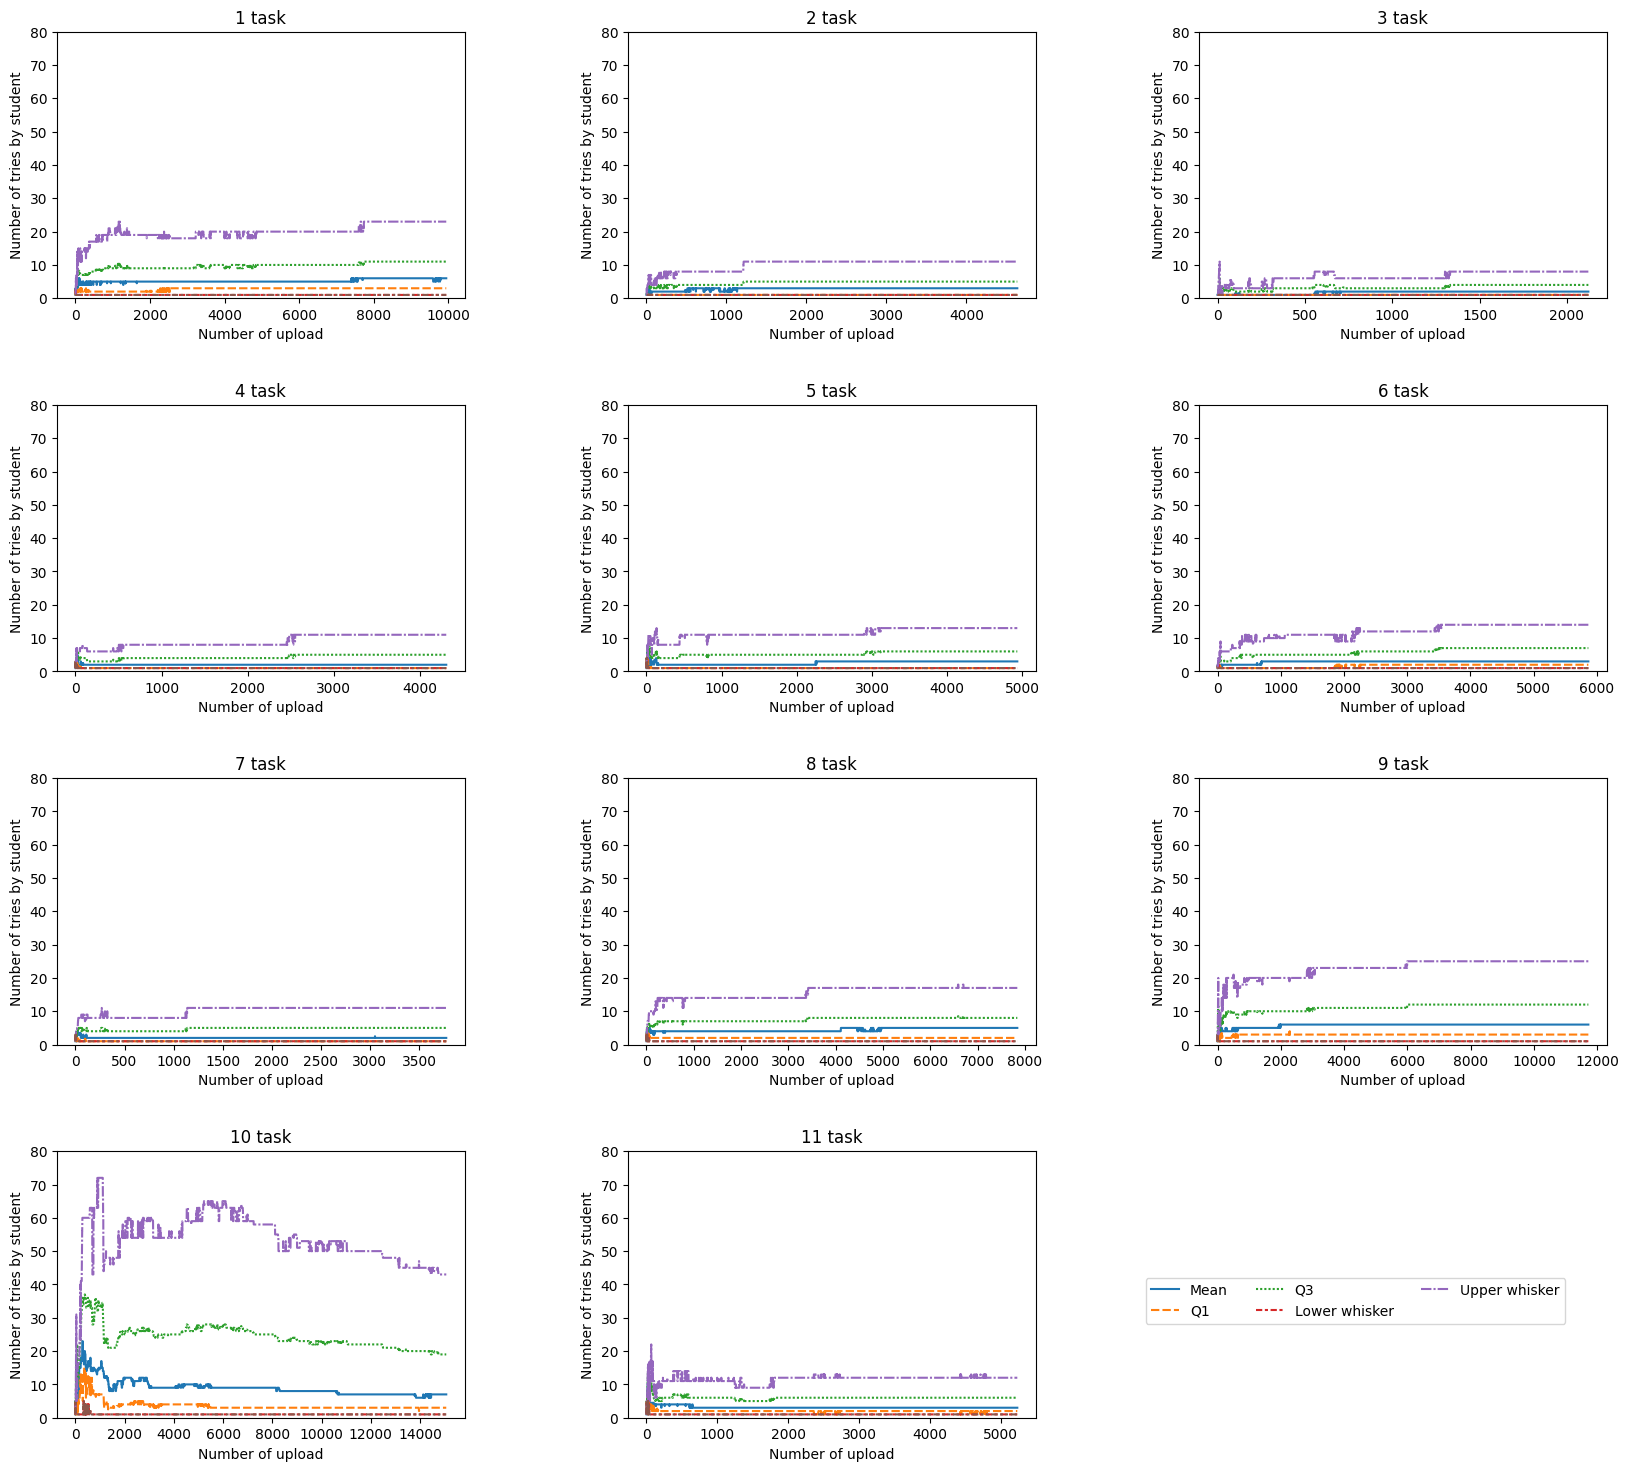

In [12]:
# sns.lineplot(data=stat_data[0])
fig = plt.figure(figsize=(20, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for index, task in enumerate(stat_data_num):
    ax = fig.add_subplot(4, 3, index + 1, ylim=(0, 80))
    ax.set_title(f"{index+1} task")
    ax.set(xlabel="Number of upload", ylabel="Number of tries by student")
    sns.lineplot(data=task[:-2], ax=ax, legend=False, label="Legend")
    handles, labels = ax.get_legend_handles_labels()
print(handles, labels)
fig.legend(
    handles,
    [
        "Mean",
        "Q1",
        "Q3",
        "Lower whisker",
        "Upper whisker",
        # "Lower outlier",
        # "Upper outlier",
    ],
    loc=(0.7, 0.1),
    ncol=3,
)
plt.show()

[<matplotlib.lines.Line2D object at 0x000002BE120D0490>, <matplotlib.lines.Line2D object at 0x000002BE120D0C10>, <matplotlib.lines.Line2D object at 0x000002BE120D0CD0>, <matplotlib.lines.Line2D object at 0x000002BE120D3D50>, <matplotlib.lines.Line2D object at 0x000002BE12039090>, <matplotlib.lines.Line2D object at 0x000002BE12068790>] ['Legend', 'Legend', 'Legend', 'Legend', 'Legend', 'Legend']


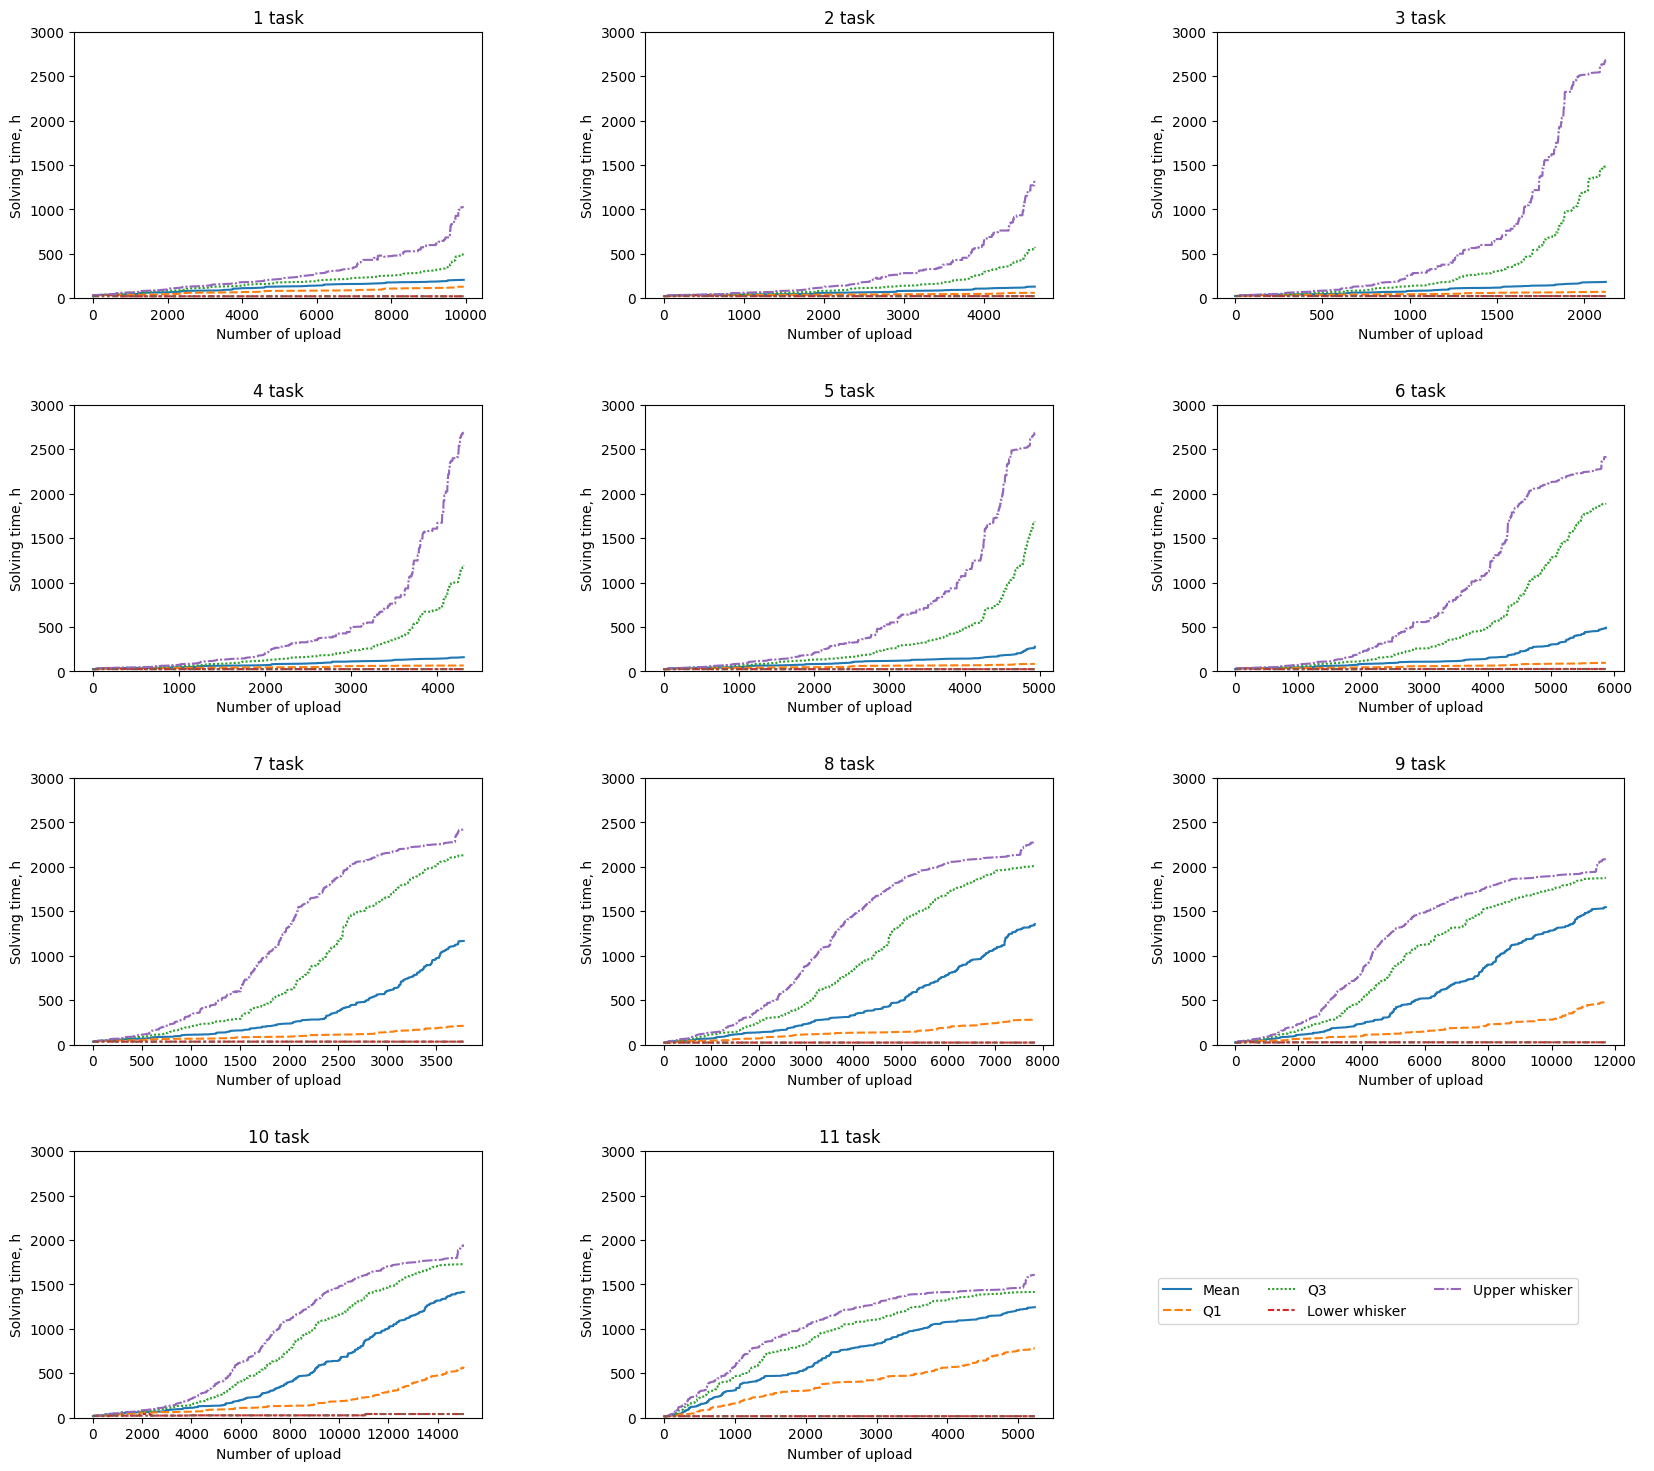

In [13]:
# sns.lineplot(data=stat_data[0])
fig = plt.figure(figsize=(20, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for index, task in enumerate(stat_data_date):
    ax = fig.add_subplot(4, 3, index + 1, ylim=(0, 3000))
    ax.set_title(f"{index+1} task")
    ax.set(xlabel="Number of upload", ylabel="Solving time, h")
    sns.lineplot(data=task[:-2], ax=ax, legend=False, label="Legend")
    handles, labels = ax.get_legend_handles_labels()
print(handles, labels)
fig.legend(
    handles,
    [
        "Mean",
        "Q1",
        "Q3",
        "Lower whisker",
        "Upper whisker",
        # "Lower outlier",
        # "Upper outlier",
    ],
    loc=(0.7, 0.1),
    ncol=3,
)
plt.show()

[<matplotlib.lines.Line2D object at 0x000002BE126A5550>, <matplotlib.lines.Line2D object at 0x000002BE126A7850>, <matplotlib.lines.Line2D object at 0x000002BE126A5450>, <matplotlib.lines.Line2D object at 0x000002BE126AF5D0>, <matplotlib.lines.Line2D object at 0x000002BE126A5F90>, <matplotlib.lines.Line2D object at 0x000002BE126AEB50>] ['Legend', 'Legend', 'Legend', 'Legend', 'Legend', 'Legend']


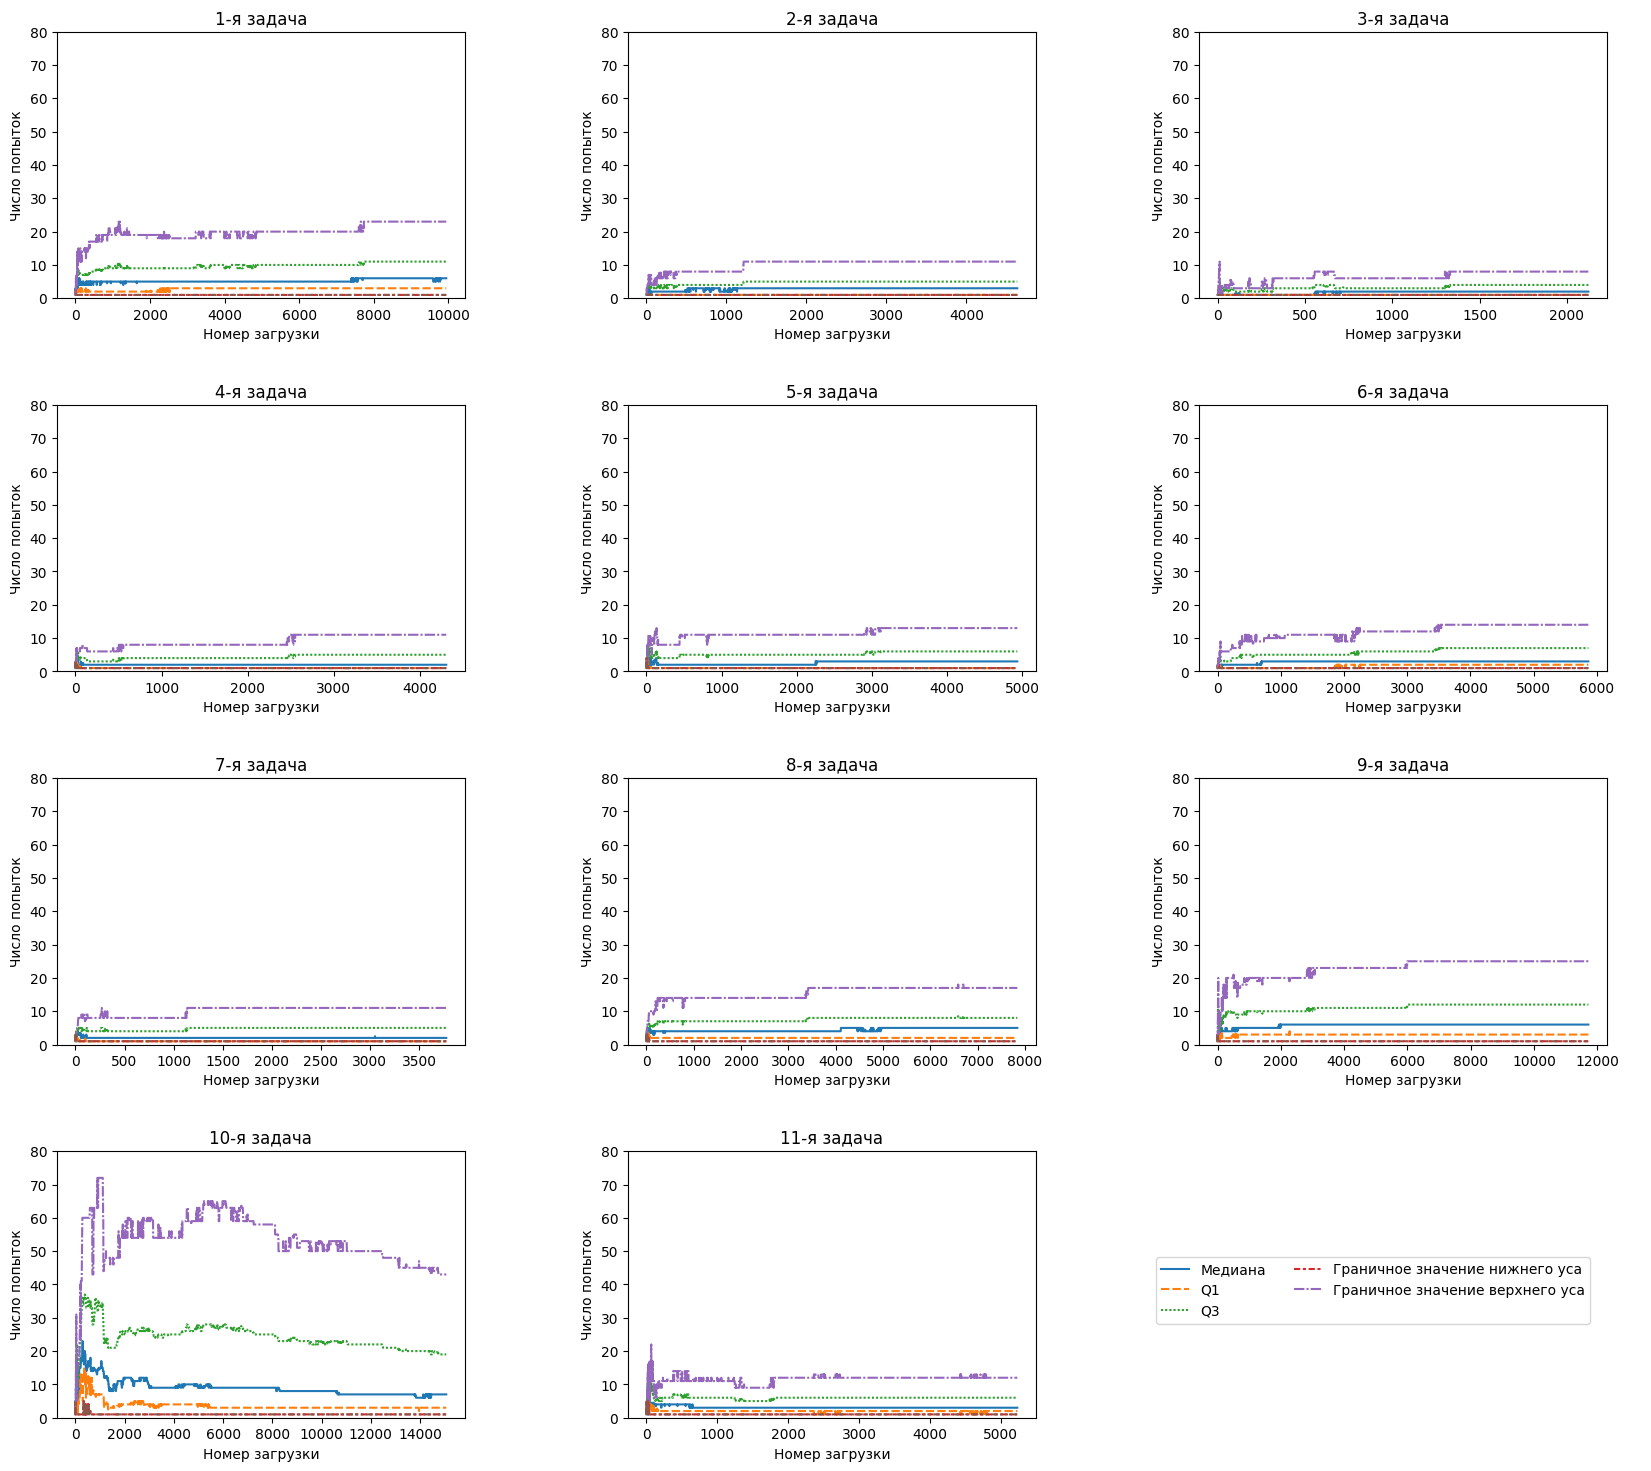

In [14]:
# sns.lineplot(data=stat_data[0])
fig = plt.figure(figsize=(20, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for index, task in enumerate(stat_data_num):
    ax = fig.add_subplot(4, 3, index + 1, ylim=(0, 80))
    ax.set_title(f"{index+1}-я задача")
    ax.set(xlabel="Номер загрузки", ylabel="Число попыток")
    sns.lineplot(data=task[:-2], ax=ax, legend=False, label="Legend")
    handles, labels = ax.get_legend_handles_labels()
print(handles, labels)
fig.legend(
    handles,
    [
        "Медиана",
        "Q1",
        "Q3",
        "Граничное значение нижнего уса",
        "Граничное значение верхнего уса",
        # "Lower outlier",
        # "Upper outlier",
    ],
    loc=(0.7, 0.1),
    ncol=2,
)
plt.show()

[<matplotlib.lines.Line2D object at 0x000002BE179244D0>, <matplotlib.lines.Line2D object at 0x000002BE17924750>, <matplotlib.lines.Line2D object at 0x000002BE17926D50>, <matplotlib.lines.Line2D object at 0x000002BE12A77F90>, <matplotlib.lines.Line2D object at 0x000002BE1791ADD0>, <matplotlib.lines.Line2D object at 0x000002BE178D6CD0>] ['Legend', 'Legend', 'Legend', 'Legend', 'Legend', 'Legend']


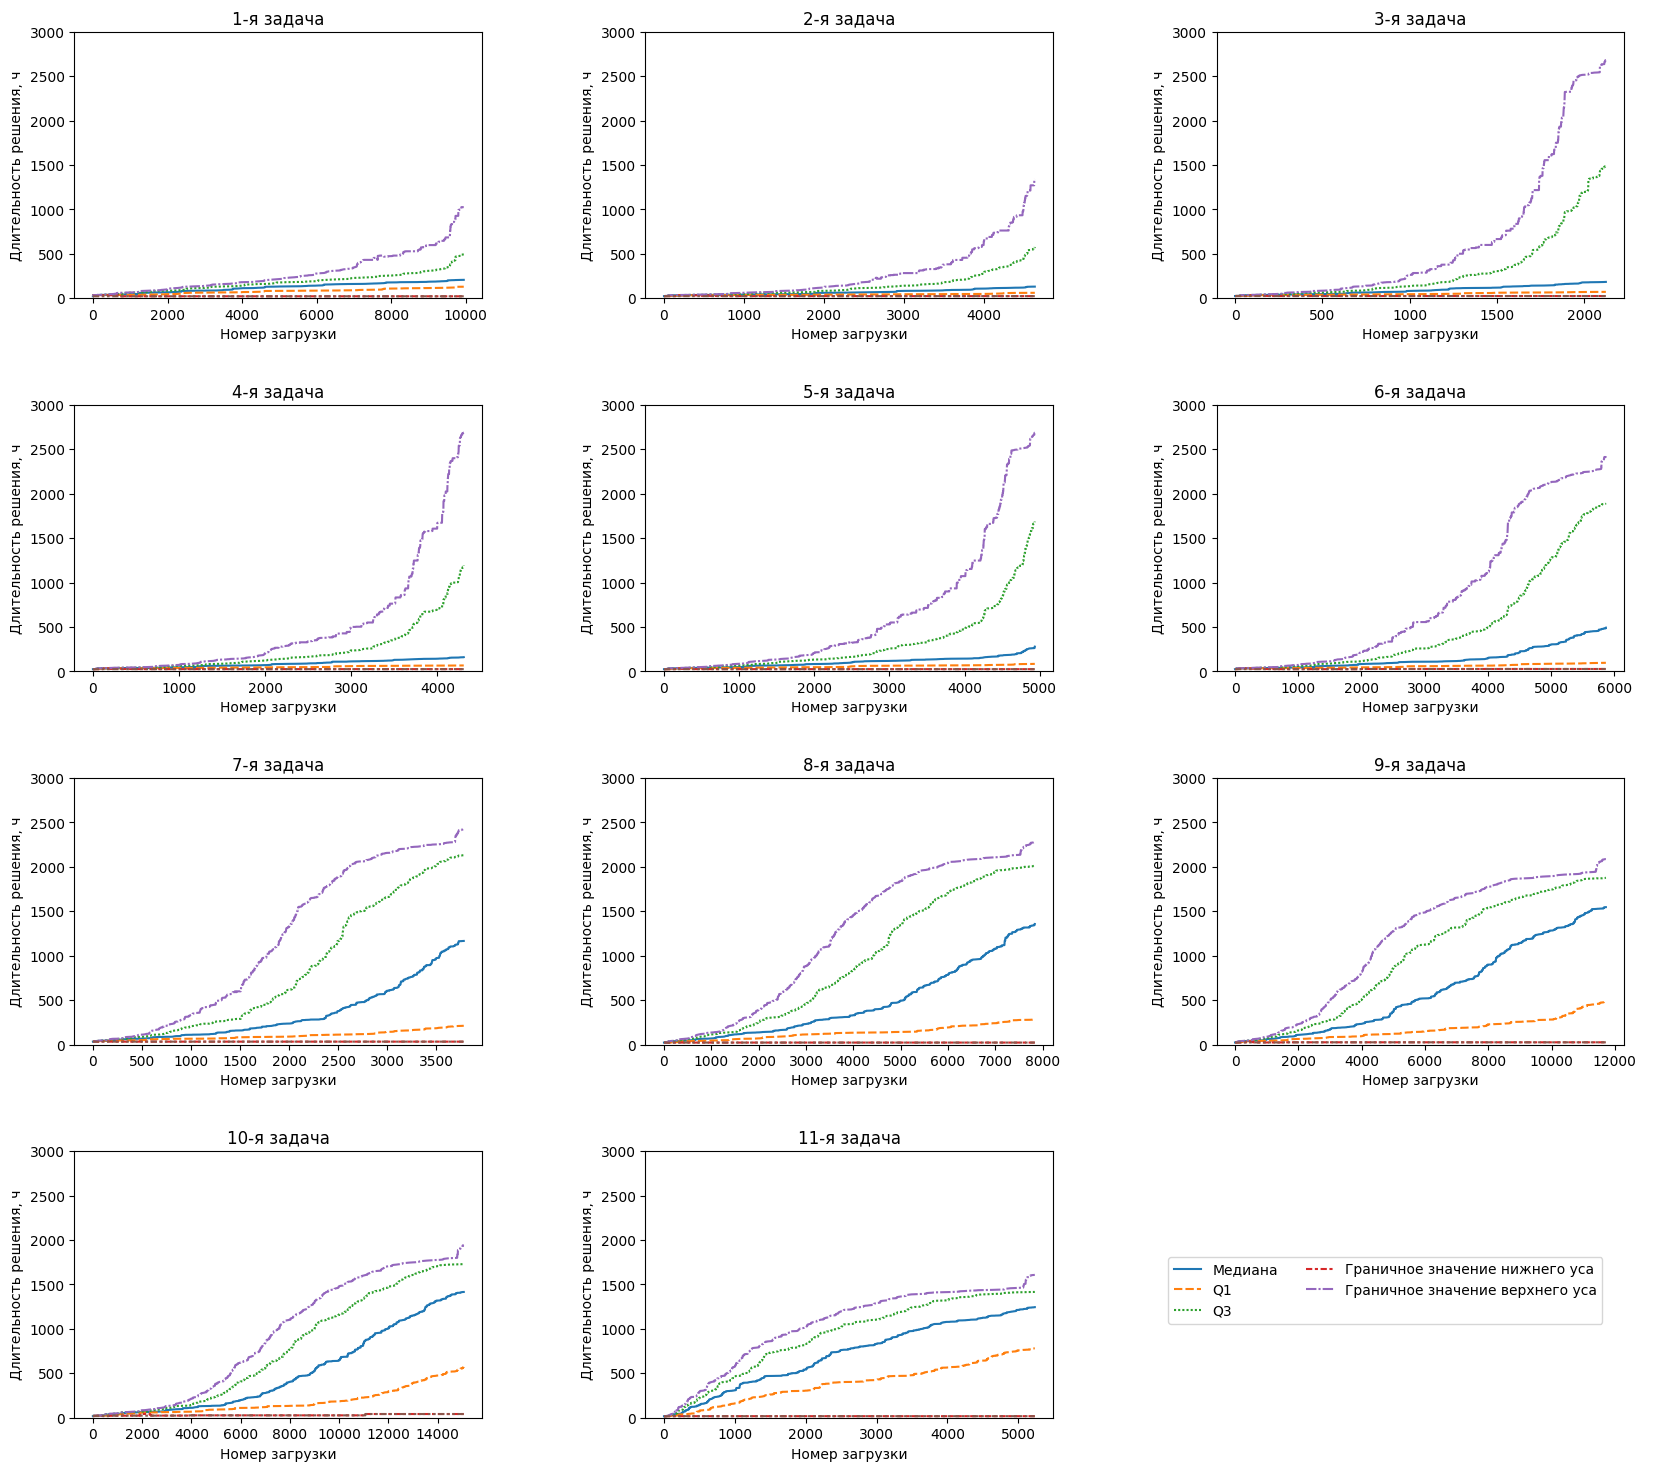

In [15]:
# sns.lineplot(data=stat_data[0])
fig = plt.figure(figsize=(20, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for index, task in enumerate(stat_data_date):
    ax = fig.add_subplot(4, 3, index + 1, ylim=(0, 3000))
    ax.set_title(f"{index+1}-я задача")
    ax.set(xlabel="Номер загрузки", ylabel="Длительность решения, ч")
    sns.lineplot(data=task[:-2], ax=ax, legend=False, label="Legend")
    handles, labels = ax.get_legend_handles_labels()
print(handles, labels)
fig.legend(
    handles,
    [
        "Медиана",
        "Q1",
        "Q3",
        "Граничное значение нижнего уса",
        "Граничное значение верхнего уса",
        # "Lower outlier",
        # "Upper outlier",
    ],
    loc=(0.7, 0.1),
    ncol=2,
)
plt.show()

In [27]:
outliers_by_date_df = outliers_by_date_df.reset_index()
outliers_by_date_df

Empty DataFrame
Columns: [index]
Index: []

In [28]:
outliers_by_date_df.groupby(["task", "time"], as_index=False).agg(
    count=("num_attempts", "size")
)

KeyError: 'task'

In [ ]:
len(outliers_by_date_df.student.unique())

524

In [ ]:
len(df.student.unique())

1423

In [ ]:
num_outliers_by_student_df = outliers_by_date_df.groupby(
    ["student"], as_index=False
).agg(num_outliers=("task", "size"))
df_outlier_outlier = (
    num_outliers_by_student_df[["student", "num_outliers"]]
    .set_index("student")
    .apply(box_outliers)
    .reset_index()
)
df_outlier_outlier

KeyError: 'student'

In [13]:
num_outliers_by_student_df

NameError: name 'num_outliers_by_student_df' is not defined

### One group DataFrame


In [4]:
# dataframe only with one group 1
df_group1 = df[df["group"] == GROUP_TO_ANALYZE]
df_group1.head()

group  task  variant                        time  status  student  \
0         1     0       39  2023-02-08 22:09:13.821983       3        1   
1         1     0       38  2023-02-08 22:10:44.827760       2        1   
1090      1     0       14  2023-02-10 14:49:53.406150       3      276   
1104      1     0       14  2023-02-10 14:54:54.093771       3      276   
1696      1     0       14  2023-02-11 02:02:57.995938       3      276   

      achievement  
0             NaN  
1             0.0  
1090          NaN  
1104          NaN  
1696          NaN

### Create DataFrame for student-group-task-variant combination


In [5]:
# groupby for "student", "group", "task", "variant" columns
df_gb_student_task_variant = df.groupby(
    ["student", "group", "task", "variant"], as_index=False
)

#### Solved column


In [6]:
# create new column
df_student_task_variant = df_gb_student_task_variant.apply(
    lambda x: 2 in x["status"].unique()
)
df_student_task_variant.columns = ["student", "group", "task", "variant", "solved"]
df_student_task_variant

student  group  task  variant  solved
0            1      1     0       38    True
1            1      1     0       39   False
2            1      4     8       39   False
3            1      6     4       12   False
4            1     14     9       13   False
...        ...    ...   ...      ...     ...
14898     1736     47     1       30    True
14899     1736     47     2       30    True
14900     1736     47     3       30    True
14901     1736     47     4       30    True
14902     1736     47     5       30   False

[14903 rows x 5 columns]

#### Solution date column


In [7]:
# create new column
df_solution_date = (
    df[df["status"] == 2]
    .groupby(["student", "group", "task", "variant"], as_index=False)
    .agg(solution_date=("time", "min"))
)
df_solution_date.columns = ["student", "group", "task", "variant", "solution_date"]

# merge new column
df_student_task_variant = pd.merge(
    df_student_task_variant,
    df_solution_date,
    on=["student", "group", "task", "variant"],
    how="left",
)
df_student_task_variant

student  group  task  variant  solved               solution_date
0            1      1     0       38    True  2023-02-08 22:10:44.827760
1            1      1     0       39   False                         NaN
2            1      4     8       39   False                         NaN
3            1      6     4       12   False                         NaN
4            1     14     9       13   False                         NaN
...        ...    ...   ...      ...     ...                         ...
14898     1736     47     1       30    True  2023-06-06 21:31:46.088896
14899     1736     47     2       30    True  2023-06-06 22:12:52.627125
14900     1736     47     3       30    True  2023-06-06 22:22:37.586111
14901     1736     47     4       30    True  2023-06-06 22:51:04.465129
14902     1736     47     5       30   False                         NaN

[14903 rows x 6 columns]

#### First attempt date column


In [8]:
# create new column
df_first_attempt_date = df_gb_student_task_variant.agg(
    first_attempt_date=("time", "min")
)

# merge new column
df_student_task_variant = pd.merge(
    df_student_task_variant,
    df_first_attempt_date,
    on=["student", "group", "task", "variant"],
)
df_student_task_variant

student  group  task  variant  solved               solution_date  \
0            1      1     0       38    True  2023-02-08 22:10:44.827760   
1            1      1     0       39   False                         NaN   
2            1      4     8       39   False                         NaN   
3            1      6     4       12   False                         NaN   
4            1     14     9       13   False                         NaN   
...        ...    ...   ...      ...     ...                         ...   
14898     1736     47     1       30    True  2023-06-06 21:31:46.088896   
14899     1736     47     2       30    True  2023-06-06 22:12:52.627125   
14900     1736     47     3       30    True  2023-06-06 22:22:37.586111   
14901     1736     47     4       30    True  2023-06-06 22:51:04.465129   
14902     1736     47     5       30   False                         NaN   

               first_attempt_date  
0      2023-02-08 22:10:44.827760  
1      2023-02-08 22:09:13.821983  
2      2023-03-15 12:59:28.533969  
3      2023-02-16 08:58:14.773529  
4      2023-04-19 21:29:33.411706  
...                           ...  
14898  2023-06-06 21:19:23.409904  
14899  2023-06-06 22:12:14.461257  
14900  2023-06-06 22:22:37.586111  
14901  2023-06-06 22:49:47.068341  
14902  2023-06-06 23:04:49.347166  

[14903 rows x 7 columns]

#### First attempt to solution time column


In [9]:
df_student_task_variant["fa_sol_time"] = pd.to_datetime(
    df_student_task_variant["solution_date"]
) - pd.to_datetime(df_student_task_variant["first_attempt_date"])
df_student_task_variant

student  group  task  variant  solved               solution_date  \
0            1      1     0       38    True  2023-02-08 22:10:44.827760   
1            1      1     0       39   False                         NaN   
2            1      4     8       39   False                         NaN   
3            1      6     4       12   False                         NaN   
4            1     14     9       13   False                         NaN   
...        ...    ...   ...      ...     ...                         ...   
14898     1736     47     1       30    True  2023-06-06 21:31:46.088896   
14899     1736     47     2       30    True  2023-06-06 22:12:52.627125   
14900     1736     47     3       30    True  2023-06-06 22:22:37.586111   
14901     1736     47     4       30    True  2023-06-06 22:51:04.465129   
14902     1736     47     5       30   False                         NaN   

               first_attempt_date            fa_sol_time  
0      2023-02-08 22:10:44.827760        0 days 00:00:00  
1      2023-02-08 22:09:13.821983                    NaT  
2      2023-03-15 12:59:28.533969                    NaT  
3      2023-02-16 08:58:14.773529                    NaT  
4      2023-04-19 21:29:33.411706                    NaT  
...                           ...                    ...  
14898  2023-06-06 21:19:23.409904 0 days 00:12:22.678992  
14899  2023-06-06 22:12:14.461257 0 days 00:00:38.165868  
14900  2023-06-06 22:22:37.586111        0 days 00:00:00  
14901  2023-06-06 22:49:47.068341 0 days 00:01:17.396788  
14902  2023-06-06 23:04:49.347166                    NaT  

[14903 rows x 8 columns]

#### Number of first attempt solutions


In [10]:
df_student_task_variant = pd.merge(
    df_student_task_variant,
    df_student_task_variant[
        df_student_task_variant["fa_sol_time"].apply(lambda x: x.total_seconds()) == 0
    ]
    .groupby(["student", "variant"], as_index=False)
    .agg(num_fa_sol=("fa_sol_time", "count")),
    how="left",
)
df_student_task_variant.sort_values("num_fa_sol", ascending=False)

student  group  task  variant  solved               solution_date  \
14659     1698     29     1       16    True  2023-05-30 14:32:41.597113   
14662     1698     29     4       16    True  2023-05-30 14:33:23.860380   
6423       736     51     9        9    True  2023-05-30 00:28:39.737866   
6424       736     51    10        9    True  2023-05-30 00:29:10.334867   
14668     1698     29    10       16    True  2023-05-30 14:34:50.782818   
...        ...    ...   ...      ...     ...                         ...   
14801     1719     47     1       10    True  2023-05-31 17:23:26.387556   
14802     1719     47     2       10    True  2023-05-31 17:40:41.099204   
14872     1732     30     0        7    True  2023-06-05 02:55:31.202666   
14873     1732     30     2        7   False                         NaN   
14877     1733     51     8       15   False                         NaN   

               first_attempt_date            fa_sol_time  num_fa_sol  
14659  2023-05-30 14:32:41.597113        0 days 00:00:00        11.0  
14662  2023-05-30 14:33:23.860380        0 days 00:00:00        11.0  
6423   2023-05-30 00:28:39.737866        0 days 00:00:00        11.0  
6424   2023-05-30 00:29:10.334867        0 days 00:00:00        11.0  
14668  2023-05-30 14:34:50.782818        0 days 00:00:00        11.0  
...                           ...                    ...         ...  
14801  2023-05-31 17:22:53.787054 0 days 00:00:32.600502         NaN  
14802  2023-05-31 17:37:40.141837 0 days 00:03:00.957367         NaN  
14872  2023-06-05 02:34:55.849988 0 days 00:20:35.352678         NaN  
14873  2023-06-05 03:15:09.320037                    NaT         NaN  
14877  2023-06-06 23:54:30.274529                    NaT         NaN  

[14903 rows x 9 columns]

#### Number of attempts before the solution


In [11]:
temp = pd.merge(
    df,
    df_student_task_variant[
        ["student", "group", "task", "variant", "first_attempt_date", "solution_date"]
    ],
    how="left",
)
temp = temp[temp["solution_date"] > temp["first_attempt_date"]]
temp = temp.groupby(["student", "group", "task", "variant"], as_index=False).agg(
    num_attempts_before_sol=("solution_date", "count")
)
df_student_task_variant = pd.merge(
    df_student_task_variant,
    temp,
    how="left",
)
df_student_task_variant["num_attempts_before_sol"] = np.where(
    df_student_task_variant["fa_sol_time"] == 0,
    0,
    df_student_task_variant["num_attempts_before_sol"],
)
df_student_task_variant

student  group  task  variant  solved               solution_date  \
0            1      1     0       38    True  2023-02-08 22:10:44.827760   
1            1      1     0       39   False                         NaN   
2            1      4     8       39   False                         NaN   
3            1      6     4       12   False                         NaN   
4            1     14     9       13   False                         NaN   
...        ...    ...   ...      ...     ...                         ...   
14898     1736     47     1       30    True  2023-06-06 21:31:46.088896   
14899     1736     47     2       30    True  2023-06-06 22:12:52.627125   
14900     1736     47     3       30    True  2023-06-06 22:22:37.586111   
14901     1736     47     4       30    True  2023-06-06 22:51:04.465129   
14902     1736     47     5       30   False                         NaN   

               first_attempt_date            fa_sol_time  num_fa_sol  \
0      2023-02-08 22:10:44.827760        0 days 00:00:00         1.0   
1      2023-02-08 22:09:13.821983                    NaT         4.0   
2      2023-03-15 12:59:28.533969                    NaT         4.0   
3      2023-02-16 08:58:14.773529                    NaT         NaN   
4      2023-04-19 21:29:33.411706                    NaT         NaN   
...                           ...                    ...         ...   
14898  2023-06-06 21:19:23.409904 0 days 00:12:22.678992         1.0   
14899  2023-06-06 22:12:14.461257 0 days 00:00:38.165868         1.0   
14900  2023-06-06 22:22:37.586111        0 days 00:00:00         1.0   
14901  2023-06-06 22:49:47.068341 0 days 00:01:17.396788         1.0   
14902  2023-06-06 23:04:49.347166                    NaT         1.0   

       num_attempts_before_sol  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  
...                        ...  
14898                      7.0  
14899                      2.0  
14900                      NaN  
14901                      4.0  
14902                      NaN  

[14903 rows x 10 columns]

#### Date gap between task release and first attempt


In [12]:
df_student_task_variant = pd.merge(df_student_task_variant, df_dates)
df_student_task_variant["release_fa_time_gap"] = (
    pd.to_datetime(df_student_task_variant["first_attempt_date"])
    - df_student_task_variant["task_release_date"]
)
df_student_task_variant

student  group  task  variant  solved               solution_date  \
0            1      1     0       38    True  2023-02-08 22:10:44.827760   
1            1      1     0       39   False                         NaN   
2            1     43     0       39   False                         NaN   
3            1     48     0       39    True  2023-02-09 13:35:39.622231   
4            1     52     0       39    True  2023-02-09 17:05:48.483566   
...        ...    ...   ...      ...     ...                         ...   
14898     1729     30     5       19    True  2023-06-02 20:04:57.720414   
14899     1731     51     5        8    True  2023-06-04 20:49:11.730396   
14900     1734     45     5       34    True  2023-06-05 18:36:00.665293   
14901     1735     10     5        9    True  2023-06-05 23:46:10.483103   
14902     1736     47     5       30   False                         NaN   

               first_attempt_date            fa_sol_time  num_fa_sol  \
0      2023-02-08 22:10:44.827760        0 days 00:00:00         1.0   
1      2023-02-08 22:09:13.821983                    NaT         4.0   
2      2023-02-27 10:02:49.737316                    NaT         4.0   
3      2023-02-09 13:20:36.422438 0 days 00:15:03.199793         4.0   
4      2023-02-09 17:04:46.001559 0 days 00:01:02.482007         4.0   
...                           ...                    ...         ...   
14898  2023-06-02 20:04:57.720414        0 days 00:00:00         9.0   
14899  2023-06-04 20:26:21.966139 0 days 00:22:49.764257         1.0   
14900  2023-06-05 18:20:45.439016 0 days 00:15:15.226277         2.0   
14901  2023-06-05 23:46:10.483103        0 days 00:00:00         3.0   
14902  2023-06-06 23:04:49.347166                    NaT         1.0   

       num_attempts_before_sol task_release_date      release_fa_time_gap  
0                          NaN        2023-02-08   0 days 22:10:44.827760  
1                          NaN        2023-02-08   0 days 22:09:13.821983  
2                          NaN        2023-02-08  19 days 10:02:49.737316  
3                         15.0        2023-02-08   1 days 13:20:36.422438  
4                          2.0        2023-02-08   1 days 17:04:46.001559  
...                        ...               ...                      ...  
14898                      NaN        2023-02-26  96 days 20:04:57.720414  
14899                     15.0        2023-02-26  98 days 20:26:21.966139  
14900                      3.0        2023-02-26  99 days 18:20:45.439016  
14901                      NaN        2023-02-26  99 days 23:46:10.483103  
14902                      NaN        2023-02-26 100 days 23:04:49.347166  

[14903 rows x 12 columns]

#### Number of achievements


In [13]:
temp = (
    df[df["status"] == 2]
    .groupby(["student", "group", "task", "variant"], as_index=False)["achievement"]
    .unique()
)
temp["num_achievement"] = temp["achievement"].apply(lambda x: len(x))
df_student_task_variant = pd.merge(df_student_task_variant, temp, how="left")
df_student_task_variant

student  group  task  variant  solved               solution_date  \
0            1      1     0       38    True  2023-02-08 22:10:44.827760   
1            1      1     0       39   False                         NaN   
2            1     43     0       39   False                         NaN   
3            1     48     0       39    True  2023-02-09 13:35:39.622231   
4            1     52     0       39    True  2023-02-09 17:05:48.483566   
...        ...    ...   ...      ...     ...                         ...   
14898     1729     30     5       19    True  2023-06-02 20:04:57.720414   
14899     1731     51     5        8    True  2023-06-04 20:49:11.730396   
14900     1734     45     5       34    True  2023-06-05 18:36:00.665293   
14901     1735     10     5        9    True  2023-06-05 23:46:10.483103   
14902     1736     47     5       30   False                         NaN   

               first_attempt_date            fa_sol_time  num_fa_sol  \
0      2023-02-08 22:10:44.827760        0 days 00:00:00         1.0   
1      2023-02-08 22:09:13.821983                    NaT         4.0   
2      2023-02-27 10:02:49.737316                    NaT         4.0   
3      2023-02-09 13:20:36.422438 0 days 00:15:03.199793         4.0   
4      2023-02-09 17:04:46.001559 0 days 00:01:02.482007         4.0   
...                           ...                    ...         ...   
14898  2023-06-02 20:04:57.720414        0 days 00:00:00         9.0   
14899  2023-06-04 20:26:21.966139 0 days 00:22:49.764257         1.0   
14900  2023-06-05 18:20:45.439016 0 days 00:15:15.226277         2.0   
14901  2023-06-05 23:46:10.483103        0 days 00:00:00         3.0   
14902  2023-06-06 23:04:49.347166                    NaT         1.0   

       num_attempts_before_sol task_release_date      release_fa_time_gap  \
0                          NaN        2023-02-08   0 days 22:10:44.827760   
1                          NaN        2023-02-08   0 days 22:09:13.821983   
2                          NaN        2023-02-08  19 days 10:02:49.737316   
3                         15.0        2023-02-08   1 days 13:20:36.422438   
4                          2.0        2023-02-08   1 days 17:04:46.001559   
...                        ...               ...                      ...   
14898                      NaN        2023-02-26  96 days 20:04:57.720414   
14899                     15.0        2023-02-26  98 days 20:26:21.966139   
14900                      3.0        2023-02-26  99 days 18:20:45.439016   
14901                      NaN        2023-02-26  99 days 23:46:10.483103   
14902                      NaN        2023-02-26 100 days 23:04:49.347166   

      achievement  num_achievement  
0           [0.0]              1.0  
1             NaN              NaN  
2             NaN              NaN  
3           [0.0]              1.0  
4           [0.0]              1.0  
...           ...              ...  
14898       [0.0]              1.0  
14899       [1.0]              1.0  
14900       [3.0]              1.0  
14901       [0.0]              1.0  
14902         NaN              NaN  

[14903 rows x 14 columns]

## Classify students by their activity


Lets suppose that we have 2 types of students: honest and cheaters. Honest students are those who solve tasks in a reasonable time and with a reasonable number of attempts. Cheaters are those who solve tasks too fast or with too many attempts. We will classify students by their activity in the following way:

- if student has less than 3 attempts before the solution and less than 3 days between first attempt and solution, we will classify him as a cheater


In [14]:
df_student_task_variant = df_student_task_variant.sort_values(
    ["solution_date"], ascending=True
)
df_student_groupby = df_student_task_variant.groupby(["student"])

In [15]:
temp = df_student_groupby.agg(
    mean_num_attempts_before_sol=("num_attempts_before_sol", "mean"),
    mean_fa_sol_time=("fa_sol_time", "mean"),
)
df_student_task_variant = pd.merge(
    df_student_task_variant, temp, how="left", on="student"
)

In [16]:
df_student_task_variant

student  group  task  variant  solved               solution_date  \
0            1      1     0       38    True  2023-02-08 22:10:44.827760   
1           19     14     0        5    True  2023-02-09 10:13:56.292136   
2           17     14     0       21    True  2023-02-09 10:24:00.646675   
3            6     14     0        2    True  2023-02-09 10:43:16.752550   
4            4     14     0        7    True  2023-02-09 10:49:02.401517   
...        ...    ...   ...      ...     ...                         ...   
14898     1496     38     5       19   False                         NaN   
14899     1517      1     5       21   False                         NaN   
14900     1647     52     5        0   False                         NaN   
14901     1693     17     5       26   False                         NaN   
14902     1736     47     5       30   False                         NaN   

               first_attempt_date            fa_sol_time  num_fa_sol  \
0      2023-02-08 22:10:44.827760        0 days 00:00:00         1.0   
1      2023-02-09 10:06:55.747618 0 days 00:07:00.544518         3.0   
2      2023-02-09 10:20:23.568528 0 days 00:03:37.078147         2.0   
3      2023-02-09 10:41:51.827276 0 days 00:01:24.925274         NaN   
4      2023-02-09 10:45:25.736533 0 days 00:03:36.664984         3.0   
...                           ...                    ...         ...   
14898  2023-04-03 02:14:59.551240                    NaT         1.0   
14899  2023-05-31 19:27:41.939237                    NaT         NaN   
14900  2023-05-24 11:53:53.171388                    NaT         4.0   
14901  2023-05-30 19:20:54.666687                    NaT         6.0   
14902  2023-06-06 23:04:49.347166                    NaT         1.0   

       num_attempts_before_sol task_release_date      release_fa_time_gap  \
0                          NaN        2023-02-08   0 days 22:10:44.827760   
1                          4.0        2023-02-08   1 days 10:06:55.747618   
2                          4.0        2023-02-08   1 days 10:20:23.568528   
3                          3.0        2023-02-08   1 days 10:41:51.827276   
4                          3.0        2023-02-08   1 days 10:45:25.736533   
...                        ...               ...                      ...   
14898                      NaN        2023-02-26  36 days 02:14:59.551240   
14899                      NaN        2023-02-26  94 days 19:27:41.939237   
14900                      NaN        2023-02-26  87 days 11:53:53.171388   
14901                      NaN        2023-02-26  93 days 19:20:54.666687   
14902                      NaN        2023-02-26 100 days 23:04:49.347166   

      achievement  num_achievement  mean_num_attempts_before_sol  \
0           [0.0]              1.0                      6.230769   
1           [2.0]              1.0                      9.625000   
2           [3.0]              1.0                      5.111111   
3           [0.0]              1.0                      7.000000   
4           [1.0]              1.0                      6.000000   
...           ...              ...                           ...   
14898         NaN              NaN                      6.250000   
14899         NaN              NaN                      8.250000   
14900         NaN              NaN                      8.000000   
14901         NaN              NaN                      2.000000   
14902         NaN              NaN                      5.000000   

               mean_fa_sol_time  
0     0 days 10:06:26.237065578  
1        0 days 00:10:27.047751  
2     5 days 15:03:54.304193636  
3        0 days 22:48:04.394270  
4     0 days 03:32:34.723202727  
...                         ...  
14898 0 days 00:10:05.500226400  
14899 0 days 00:00:25.188728090  
14900 0 days 00:40:59.113524600  
14901 0 days 00:00:59.181888857  
14902 0 days 00:05:31.334311800  

[14903 rows x 16 columns]

In [17]:
df_student_task_variant["cheater"] = (
    df_student_task_variant["mean_fa_sol_time"] < pd.Timedelta(days=3)
) & (df_student_task_variant["mean_num_attempts_before_sol"] < 3)
df_student_task_variant["cheater"].value_counts()

cheater
False    14307
True       596
Name: count, dtype: int64

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score

ModuleNotFoundError: No module named 'sklearn'

## Plots


### Heatmap


In [28]:
# groupby two columns and count
df_group1[df_group1["status"] == 3].groupby(["student", "task"]).size()

NameError: name 'df_group1' is not defined

In [29]:
df_group_1_hm = (
    df_group1[df_group1["status"] == 3]
    .groupby(["student", "task"])
    .size()
    .unstack(level=1)
)
df_group_1_hm = df_group_1_hm.apply(lambda x: x.max() - x)
df_group_1_hm

NameError: name 'df_group1' is not defined

In [30]:
plt.figure(figsize=(14, 7))
sns.heatmap(data=df_group_1_hm, annot=True)

NameError: name 'df_group_1_hm' is not defined

<Figure size 1400x700 with 0 Axes>

### Boxplot


#### Average overall


In [31]:
df_student_group = (
    df_student_task_variant[df_student_task_variant["solved"] == True]
    .groupby(["student", "group"], as_index=False)
    .agg(
        avg_fa_sol_time=("fa_sol_time", "mean"),
        avg_num_attempts_before_sol=("num_attempts_before_sol", "mean"),
        avg_release_fa_time_gap=("release_fa_time_gap", "mean"),
        avg_num_achievement=("num_achievement", "mean"),
    )
)
df_student_group

student  group           avg_fa_sol_time  avg_num_attempts_before_sol  \
0           1      1           0 days 00:00:00                          NaN   
1           1     42           0 days 00:00:00                          NaN   
2           1     43 0 days 00:00:19.147333500                     2.000000   
3           1     48    0 days 03:31:19.390128                    11.800000   
4           1     52 0 days 20:55:18.059835375                     2.857143   
...       ...    ...                       ...                          ...   
1449     1732     30    0 days 00:20:35.352678                     7.000000   
1450     1733     51 0 days 00:02:49.583035800                     3.333333   
1451     1734     45 0 days 00:03:56.012707800                     3.000000   
1452     1735     10 0 days 07:35:39.239115818                     6.875000   
1453     1736     47 0 days 00:05:31.334311800                     5.000000   

         avg_release_fa_time_gap  avg_num_achievement  
0         0 days 22:10:44.827760             1.000000  
1        18 days 16:20:08.999713             1.000000  
2     51 days 23:55:39.558875500             1.000000  
3     15 days 12:43:00.798026142             1.428571  
4      7 days 23:49:28.357843375             1.125000  
...                          ...                  ...  
1449    117 days 02:34:55.849988             1.000000  
1450     86 days 03:54:31.056453             1.000000  
1451 109 days 22:27:11.546056400             1.000000  
1452  99 days 01:45:08.646837001             1.000000  
1453    113 days 07:32:07.766098             1.000000  

[1454 rows x 6 columns]

<Axes: >

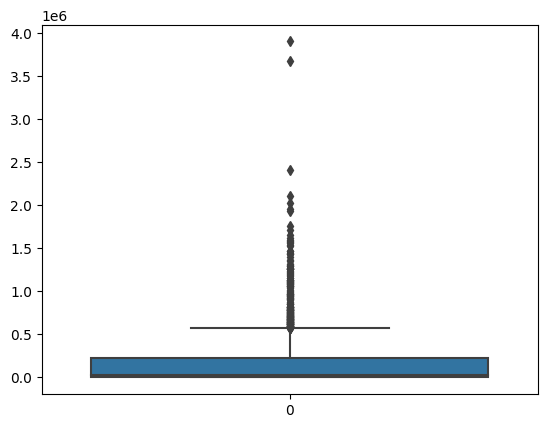

In [32]:
sns.boxplot(df_student_group["avg_fa_sol_time"].dt.total_seconds())

<Axes: >

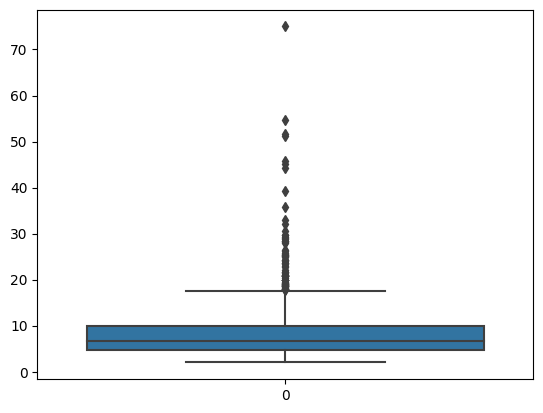

In [33]:
sns.boxplot(df_student_group["avg_num_attempts_before_sol"])

<Axes: >

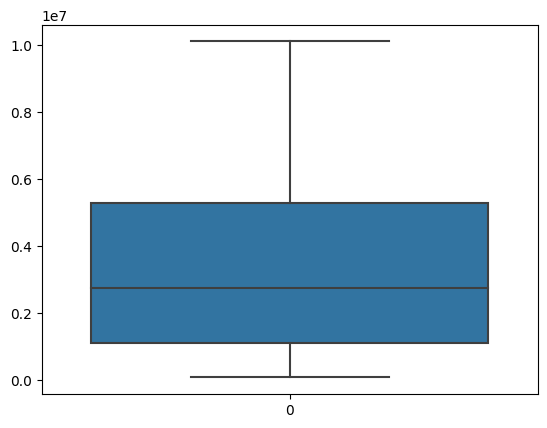

In [34]:
sns.boxplot(df_student_group["avg_release_fa_time_gap"].dt.total_seconds())

<Axes: >

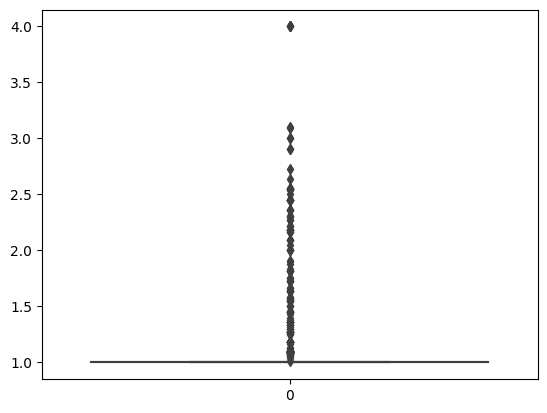

In [35]:
sns.boxplot(df_student_group["avg_num_achievement"])

#### Average by day and task
